# Spatial autocorrelation 
* Guides with codes on https://geographicdata.science/book/notebooks/06_spatial_autocorrelation.html
* Here we use data aggregated by CDUID
    * /dataset/canada-census-division/CD-download-data.shp
* Boundary data obtained from https://www12.statcan.gc.ca/census-recensement/2011/geo/bound-limit/bound-limit-2016-eng.cfm



In [ ]:
# To do:
# Test this with no external boundary data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install geopandas &> /dev/null
import os
import pandas as pd
import pickle
import geopandas as gpd
import numpy as np

# Autocorrelation and plotting modules
!pip install pysal contextily &> /dev/null
import matplotlib.pyplot as plt
import seaborn
from pysal.viz import splot
from splot.esda import plot_moran

import contextily
import pandas as pd
from pysal.explore import esda
from pysal.lib import weights
from numpy.random import seed

os.chdir('/content/drive/MyDrive/shared/ssc22-case-comp/dataset/')
print(os.getcwd())

Mounted at /content/drive


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
/usr/local/lib/python3.7/dist-packages/spaghetti/network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


/content/drive/MyDrive/shared/dataset


Here we perform spatial autocorrelation using the aggregated data.

In [2]:
# Load CD downlaod data
# dat_path = './canada-census-division/CD-download-data.shp'
dat_path = './boundaries/statcan-dissemination-areas/DA-download-data.shp'

dat = gpd.read_file(dat_path)
print(dat.shape)
print(dat.columns)
dat.head(5)

(56589, 37)
Index(['DAUID', 'PRUID', 'PRNAME', 'CDUID', 'CDNAME', 'CDTYPE', 'CCSUID',
       'CCSNAME', 'CSDUID', 'CSDNAME', 'CSDTYPE', 'ERUID', 'ERNAME', 'SACCODE',
       'SACTYPE', 'CMAUID', 'CMAPUID', 'CMANAME', 'CMATYPE', 'CTUID', 'CTNAME',
       'ADAUID', '2019-Q1', '2019-Q2', '2019-Q3', '2019-Q4', '2020-Q1',
       '2020-Q2', '2020-Q3', '2020-Q4', '2021-Q1', '2021-Q2', '2021-Q3',
       '2021-Q4', 'tests', 'DA_POP', 'geometry'],
      dtype='object')


,DAUID,PRUID,PRNAME,CDUID,CDNAME,CDTYPE,CCSUID,CCSNAME,CSDUID,CSDNAME,...,2020-Q2,2020-Q3,2020-Q4,2021-Q1,2021-Q2,2021-Q3,2021-Q4,tests,DA_POP,geometry
0,10010244,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,1001,Division No. 1,CDR,1001519,St. John's,1001519,St. John's,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((8976851.149 2149576.543, 8976818.149..."
1,10010245,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,1001,Division No. 1,CDR,1001519,St. John's,1001519,St. John's,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((8977202.180 2150836.794, 8977136.277..."
2,10010246,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,1001,Division No. 1,CDR,1001519,St. John's,1001519,St. John's,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((8977549.383 2150892.566, 8977492.269..."
3,10010247,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,1001,Division No. 1,CDR,1001519,St. John's,1001519,St. John's,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((8977682.314 2151083.183, 8977689.440..."
4,10010248,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,1001,Division No. 1,CDR,1001519,St. John's,1001519,St. John's,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((8978152.474 2151142.586, 8978040.654..."


In [3]:
dat.info() ## it looks like there are still null values.

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 56589 entries, 0 to 56588
Data columns (total 37 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   DAUID     56589 non-null  object  
 1   PRUID     56589 non-null  object  
 2   PRNAME    56589 non-null  object  
 3   CDUID     56589 non-null  object  
 4   CDNAME    56589 non-null  object  
 5   CDTYPE    56589 non-null  object  
 6   CCSUID    56589 non-null  object  
 7   CCSNAME   56589 non-null  object  
 8   CSDUID    56589 non-null  object  
 9   CSDNAME   56589 non-null  object  
 10  CSDTYPE   56589 non-null  object  
 11  ERUID     56589 non-null  object  
 12  ERNAME    56589 non-null  object  
 13  SACCODE   56589 non-null  object  
 14  SACTYPE   56589 non-null  object  
 15  CMAUID    43746 non-null  object  
 16  CMAPUID   43746 non-null  object  
 17  CMANAME   43746 non-null  object  
 18  CMATYPE   43746 non-null  object  
 19  CTUID     38289 non-null  object  
 20

In [10]:
inds = np.unique(np.where(pd.isnull(dat['2021-Q3']))[0])
dat.loc[inds]

,DAUID,PRUID,PRNAME,CDUID,CDNAME,CDTYPE,CCSUID,CCSNAME,CSDUID,CSDNAME,...,2020-Q2,2020-Q3,2020-Q4,2021-Q1,2021-Q2,2021-Q3,2021-Q4,tests,DA_POP,geometry
0,10010244,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,1001,Division No. 1,CDR,1001519,St. John's,1001519,St. John's,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((8976851.149 2149576.543, 8976818.149..."
1,10010245,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,1001,Division No. 1,CDR,1001519,St. John's,1001519,St. John's,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((8977202.180 2150836.794, 8977136.277..."
2,10010246,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,1001,Division No. 1,CDR,1001519,St. John's,1001519,St. John's,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((8977549.383 2150892.566, 8977492.269..."
3,10010247,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,1001,Division No. 1,CDR,1001519,St. John's,1001519,St. John's,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((8977682.314 2151083.183, 8977689.440..."
4,10010248,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,1001,Division No. 1,CDR,1001519,St. John's,1001519,St. John's,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((8978152.474 2151142.586, 8978040.654..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56581,59390189,59,British Columbia / Colombie-Britannique,5939,Columbia-Shuswap,RD,5939039,Columbia-Shuswap D,5939032,Salmon Arm,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((4336932.623 2025546.631, 4337151.209..."
56582,59530199,59,British Columbia / Colombie-Britannique,5953,Fraser-Fort George,RD,5953048,Fraser-Fort George F,5953033,Mackenzie,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,1040.0,"POLYGON ((4339069.071 2595378.469, 4337222.406..."
56586,59530208,59,British Columbia / Colombie-Britannique,5953,Fraser-Fort George,RD,5953042,Fraser-Fort George C,5953023,Prince George,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((4283348.986 2454686.740, 4283327.897..."
56587,59530209,59,British Columbia / Colombie-Britannique,5953,Fraser-Fort George,RD,5953042,Fraser-Fort George C,5953023,Prince George,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((4282932.354 2455406.546, 4283303.163..."


In [11]:
dat2 = dat.drop(inds)
dat2.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 14624 entries, 5 to 56585
Data columns (total 37 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   DAUID     14624 non-null  object  
 1   PRUID     14624 non-null  object  
 2   PRNAME    14624 non-null  object  
 3   CDUID     14624 non-null  object  
 4   CDNAME    14624 non-null  object  
 5   CDTYPE    14624 non-null  object  
 6   CCSUID    14624 non-null  object  
 7   CCSNAME   14624 non-null  object  
 8   CSDUID    14624 non-null  object  
 9   CSDNAME   14624 non-null  object  
 10  CSDTYPE   14624 non-null  object  
 11  ERUID     14624 non-null  object  
 12  ERNAME    14624 non-null  object  
 13  SACCODE   14624 non-null  object  
 14  SACTYPE   14624 non-null  object  
 15  CMAUID    5685 non-null   object  
 16  CMAPUID   5685 non-null   object  
 17  CMANAME   5685 non-null   object  
 18  CMATYPE   5685 non-null   object  
 19  CTUID     3828 non-null   object  
 20

In [12]:
# cols = np.append(np.array(dat2.columns[range(5,17)]), dat2.columns[19])
cols = ['DAUID', '2019-Q1', '2019-Q2','2019-Q3', '2019-Q4','2020-Q1',	'2020-Q2',	'2020-Q3',	'2020-Q4',	'2021-Q1',	'2021-Q2',	'2021-Q3',	'2021-Q4', 'tests','DA_POP', 'geometry']
sub_dat = dat2[cols]
# sub_dat = dat2[cols]
sub_dat.head()

,DAUID,2019-Q1,2019-Q2,2019-Q3,2019-Q4,2020-Q1,2020-Q2,2020-Q3,2020-Q4,2021-Q1,2021-Q2,2021-Q3,2021-Q4,tests,DA_POP,geometry
5,10010249,NaN,NaN,NaN,NaN,NaN,6.721000,1.639000,NaN,NaN,52.068000,39.515000,154.563000,70.0,6110.0,"POLYGON ((8977690.386 2151443.737, 8977686.806..."
49,10010191,97.366333,117.839300,142.273923,216.091000,157.276556,117.459250,90.400814,168.794455,142.713238,234.337602,129.232029,135.353682,820.0,48575.0,"POLYGON ((8981987.986 2153965.966, 8981992.077..."
98,10010486,58.868750,79.212000,46.574429,103.873200,155.954000,57.149000,285.421000,167.028786,158.998556,112.139167,209.289731,133.595400,216.0,37950.0,"POLYGON ((8981595.731 2155809.606, 8981603.223..."
107,10010496,96.455000,1.825191,16.800500,72.112500,81.069000,20.306933,28.656455,49.555909,48.839915,83.304636,56.000000,1.299000,201.0,11060.0,"POLYGON ((8935642.709 2196311.271, 8935686.551..."
108,10010497,118.833000,33.624000,194.869612,77.605857,160.630833,175.920000,265.376333,128.304200,73.366615,93.629333,76.171300,238.869429,148.0,22080.0,"MULTIPOLYGON (((8928320.397 2199041.249, 89283..."


In [40]:
# Set the upper limit of avg_d_mbps at 100

indsQ1 = sub_dat.index[sub_dat['2019-Q1'] > 100].to_list()
sub_dat['2019-Q1-mod'] = sub_dat['2019-Q1']
sub_dat['2019-Q1-mod'][indsQ1] = 100

indsQ3 = sub_dat.index[sub_dat['2021-Q3'] > 100].to_list()
sub_dat['2021-Q3-mod'] = sub_dat['2021-Q3']
sub_dat['2021-Q3-mod'][indsQ3] = 100


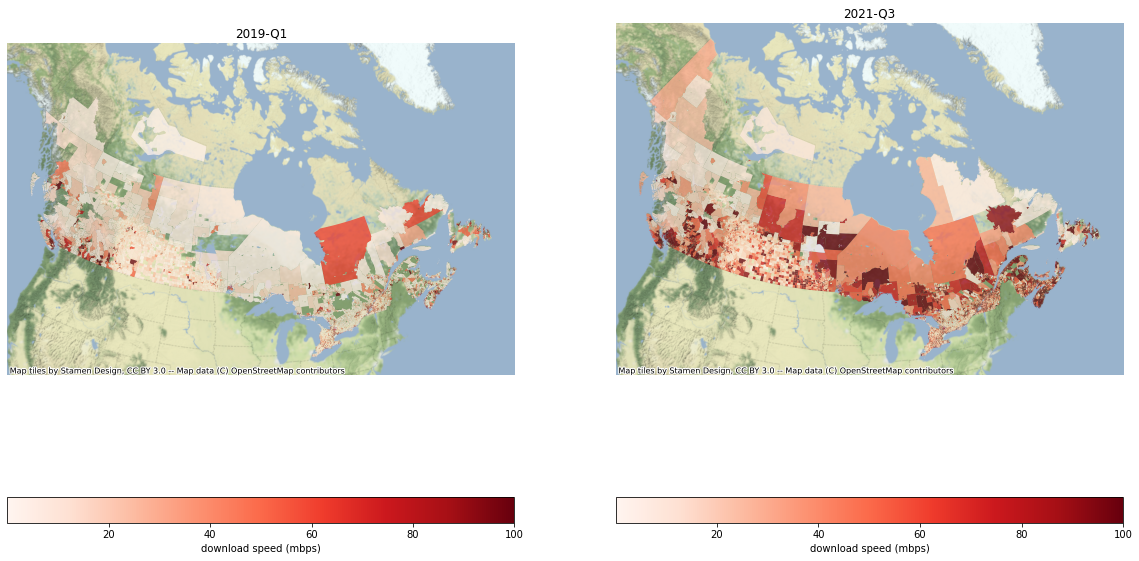

In [44]:
f, axs = plt.subplots(1,2, figsize=(20,15))
ax1, ax2 = axs

sub_dat.plot(column = '2019-Q1-mod',
            #  cmap='Greens_r',
            #  cmap='viridis',
             cmap='Reds',
            #  scheme='quantiles',
            #  k=5,
             edgecolor='white',
             linewidth=0.,
             alpha=0.75,
             legend=True,
             legend_kwds={'label': "download speed (mbps)",
                        'orientation': "horizontal"},
             ax=ax1)

contextily.add_basemap(ax1, 
                       crs=sub_dat.crs, 
                       source=contextily.providers.Stamen.TerrainBackground
                      )
ax1.set_title("2019-Q1")
ax1.set_axis_off()

sub_dat.plot(column = '2021-Q3-mod',
            #  cmap='Greens_r',
            #  cmap='viridis',
             cmap='Reds',
            #  scheme='quantiles',
            #  k=5,
             edgecolor='white',
             linewidth=0.,
             alpha=0.75,
             legend=True,
            legend_kwds={'label': "download speed (mbps)",
                        'orientation': "horizontal"},
             ax=ax2)

contextily.add_basemap(ax2, 
                       crs=sub_dat.crs, 
                       source=contextily.providers.Stamen.TerrainBackground
                      )
ax2.set_title("2021-Q3")
ax2.set_axis_off()


## Apply smoothing by global autocorrelation using Spatial lag
* Spatial lag provides 'weighted average' of neighbouring tiles


In [51]:
# Global autocorrelation

# Smooths out the borders by the k nearest neighbours
w = weights.KNN.from_dataframe(sub_dat, k=50) # larger the k, smoother the boundaries

w.transform = 'R' # row-standardization
sub_dat['2021-Q3_lag'] = weights.spatial_lag.lag_spatial(w, sub_dat['2021-Q3-mod'])
# Here, sub_dat['2021-Q3_lag'].max() is 97

In [59]:
# Global autocorrelation: Smooths out the borders by the k nearest neighbours

# k=25
w1 = weights.KNN.from_dataframe(sub_dat, k=25) # larger the k, smoother the boundaries
w1.transform = 'R' # row-standardization
sub_dat['2021-Q3_lag1'] = weights.spatial_lag.lag_spatial(w1, sub_dat['2021-Q3'])
# sub_dat['2021-Q3_lag'].max() # Here, sub_dat['2021-Q3_lag'].max() is 195
inds_lag1 = sub_dat.index[sub_dat['2021-Q3_lag1']>100].to_list()
sub_dat['2021-Q3_lag1'][inds_lag1] = 100

# k=50
w2 = weights.KNN.from_dataframe(sub_dat, k=50) # larger the k, smoother the boundaries
w2.transform = 'R' # row-standardization
sub_dat['2021-Q3_lag2'] = weights.spatial_lag.lag_spatial(w2, sub_dat['2021-Q3'])
# sub_dat['2021-Q3_lag'].max() # Here, sub_dat['2021-Q3_lag'].max() is 195
inds_lag2 = sub_dat.index[sub_dat['2021-Q3_lag2']>100].to_list()
sub_dat['2021-Q3_lag2'][inds_lag2] = 100

# k=100
w3 = weights.KNN.from_dataframe(sub_dat, k=100) # larger the k, smoother the boundaries
w3.transform = 'R' # row-standardization
sub_dat['2021-Q3_lag3'] = weights.spatial_lag.lag_spatial(w3, sub_dat['2021-Q3'])
# sub_dat['2021-Q3_lag'].max() # Here, sub_dat['2021-Q3_lag'].max() is 195
inds_lag3 = sub_dat.index[sub_dat['2021-Q3_lag3']>100].to_list()
sub_dat['2021-Q3_lag3'][inds_lag3] = 100




In [63]:
[ax1, ax2], [ax3, ax4] = axs
ax2

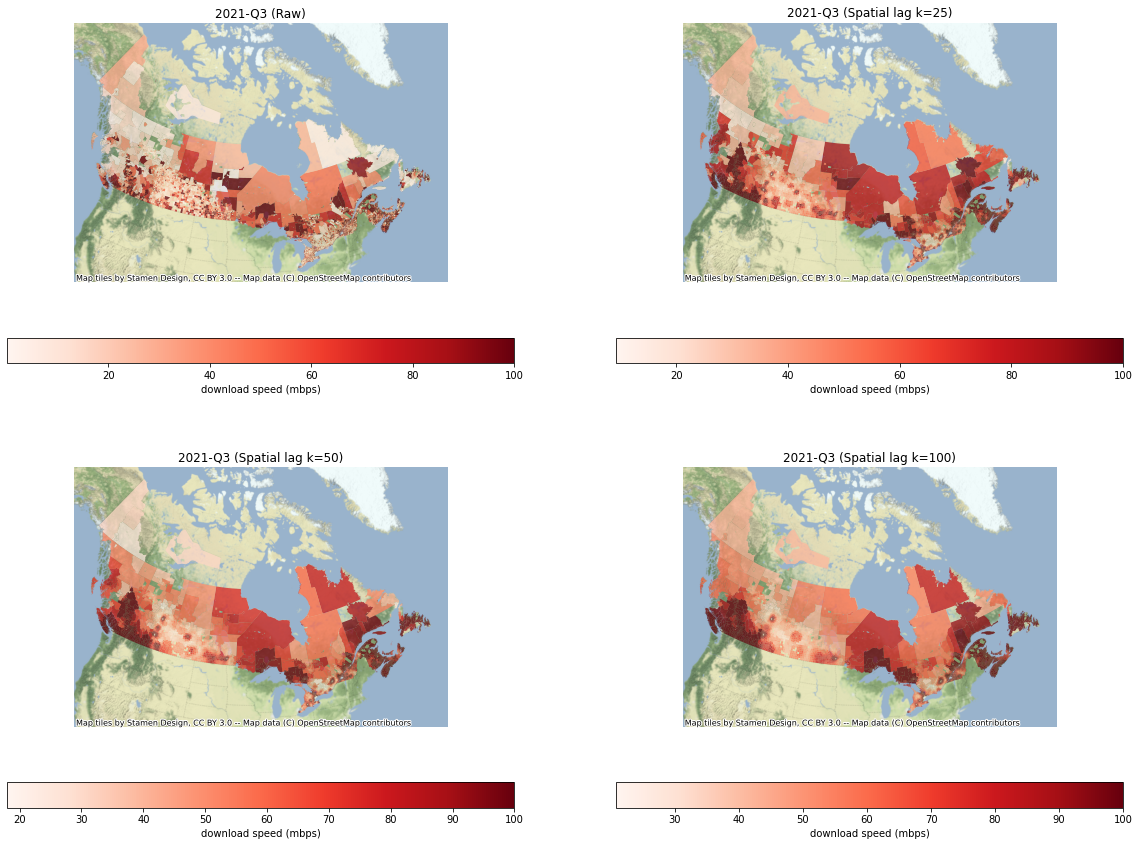

In [69]:
## Plot: raw data vs. spatial lag 

# raw data 
f, axs = plt.subplots(2, 2, figsize=(20,15))
[ax1, ax2], [ax3, ax4] = axs

sub_dat.plot(column='2021-Q3-mod', 
            #  cmap='viridis', 
             cmap = 'Reds',
            #  scheme='quantiles',
            #  k=5, 
            edgecolor='white', 
             linewidth=0., 
             alpha=0.75, 
             legend=True, 
             legend_kwds={'label': "download speed (mbps)",
                        'orientation': "horizontal"},
             ax=ax1)
ax1.set_axis_off()
ax1.set_title("2021-Q3 (Raw)")
contextily.add_basemap(ax1, 
                       crs=sub_dat.crs, 
                       source=contextily.providers.Stamen.TerrainBackground,
                      )

# k=25
sub_dat.plot(column='2021-Q3_lag1', 
            #  cmap='viridis', 
            #  scheme='quantiles',
            # k=5, 
             cmap = 'Reds',
             edgecolor='white', 
             linewidth=0., 
             alpha=0.75, 
             legend=True,
             legend_kwds={'label': "download speed (mbps)",
                        'orientation': "horizontal"}, 
             ax=ax2)
ax2.set_axis_off()
ax2.set_title("2021-Q3 (Spatial lag k=25)")
contextily.add_basemap(ax2, 
                       crs=sub_dat.crs, 
                       source=contextily.providers.Stamen.TerrainBackground,
                      )

# k=50
sub_dat.plot(column='2021-Q3_lag2', 
            #  cmap='viridis', 
            #  scheme='quantiles',
            # k=5, 
             cmap = 'Reds',
             edgecolor='white', 
             linewidth=0., 
             alpha=0.75, 
             legend=True,
             legend_kwds={'label': "download speed (mbps)",
                        'orientation': "horizontal"}, 
             ax=ax3)
ax3.set_axis_off()
ax3.set_title("2021-Q3 (Spatial lag k=50)")
contextily.add_basemap(ax3, 
                       crs=sub_dat.crs, 
                       source=contextily.providers.Stamen.TerrainBackground,
                      )

# k=100
sub_dat.plot(column='2021-Q3_lag3', 
            #  cmap='viridis', 
            #  scheme='quantiles',
            # k=5, 
             cmap = 'Reds',
             edgecolor='white', 
             linewidth=0., 
             alpha=0.75, 
             legend=True,
             legend_kwds={'label': "download speed (mbps)",
                        'orientation': "horizontal"}, 
             ax=ax4)
ax4.set_axis_off()
ax4.set_title("2021-Q3 (Spatial lag k=100)")
contextily.add_basemap(ax4, 
                       crs=sub_dat.crs, 
                       source=contextily.providers.Stamen.TerrainBackground,
                      )

plt.show()

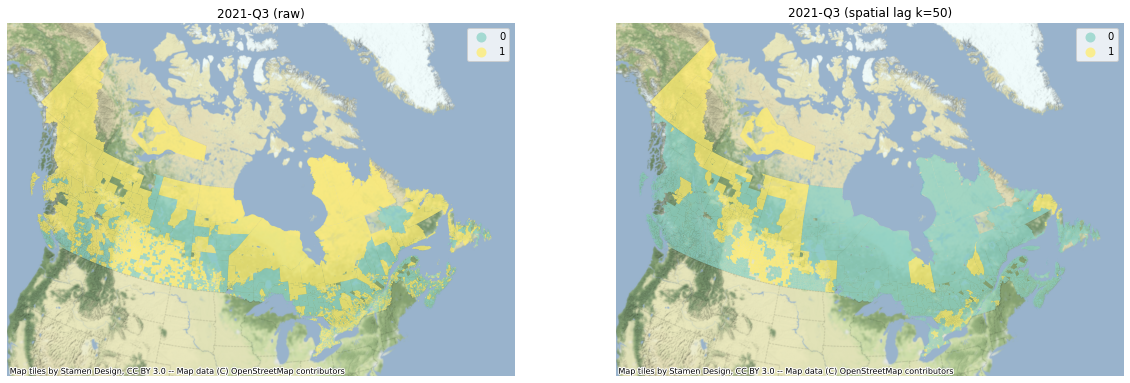

In [70]:
# Plot: binary case (< 50)

sub_dat['binary_raw'] = (sub_dat['2021-Q3'] < 50).astype(int)
sub_dat['binary_lag'] = (sub_dat['2021-Q3_lag2'] < 50).astype(int)

f, axs = plt.subplots(1, 2, figsize=(20, 11))
ax1, ax2 = axs

sub_dat.plot(ax=ax1, 
             column='binary_raw', 
             categorical=True, 
             legend=True, 
             edgecolor='0.5', 
             linewidth=0., 
             alpha=0.75, 
             cmap='Set3', 
             # cmap = 'viridis'
             
        );
ax1.set_axis_off()
ax1.set_title('2021-Q3 (raw)')
contextily.add_basemap(ax1, 
                       crs=sub_dat.crs, 
                       source=contextily.providers.Stamen.TerrainBackground,
                      )
# plt.axis('equal')

sub_dat.plot(ax=ax2, 
             column='binary_lag', 
             categorical=True, 
             legend=True, 
             edgecolor='0.5', 
             linewidth=0., 
             alpha=0.75, 
             cmap='Set3', 
             # cmap = 'viridis'
             
        );
ax2.set_axis_off()
ax2.set_title('2021-Q3 (spatial lag k=50)')
contextily.add_basemap(ax2, 
                       crs=sub_dat.crs, 
                       source=contextily.providers.Stamen.TerrainBackground,
                      )

plt.show()

It looks like it is more common to have internet speed $<$50 mbps in the western part of the country.